### Create a .yaml "driver" file with assumptions that we may want to change over time.

The cargo and fuel capacity values and references are in [this google spreadsheet](https://docs.google.com/spreadsheets/d/1URKN77iQHN-2cAVfG5T7SEiDTLTcolqL/edit#gid=1024416588)


**To do**: 
- Update barge and ATB min/max fuel values to come from .xlsx spreadsheet rather than being hard-coded

In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
from monte_carlo_utils import make_bins, get_bin, place_into_bins

### Dictionary

In [2]:
output_directory = pathlib.Path(
    '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/'
)
output_file      = output_directory / 'master.yaml'

master = {}

#~~~ Input files and location ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# create a section for directories and filenames
# US_origin is for US as origin
# US_all represents the combined import and export of fuel
master['directories'] = {}
master['directories']['data'] = pathlib.Path(
    '/Users/rmueller/Projects/MIDOSS/analysis-rachael/' +
    'notebooks/monte_carlo/data'
)
master['files'] = {}
# yaml files with Dept. of Ecology oil transfer data organized by origin/destination flags
master['files']['CAD_origin']     = master['directories']['data']/'CAD_origin.yaml'
master['files']['WA_destination'] = master['directories']['data']/'WA_destination.yaml'
master['files']['WA_origin']      = master['directories']['data']/'WA_origin.yaml'
master['files']['US_origin']      = master['directories']['data']/'US_origin.yaml'
master['files']['US_combined']    = master['directories']['data']/'US_all.yaml'
master['files']['Pacific_origin'] = master['directories']['data']/'Pacific_origin.yaml'
master['files']['fuel']           = master['directories']['data']/'fuel_by_vessel.yaml'
# excel spreadsheet with oil capacity data for all vessel types
master['files']['oil_capacity']   = master['directories']['data']/'oil_capacity.xlsx'
# weights for allocating tank barge capacities for ATBs < 50 m and tank barges 
master['files']['barge_weights']  = master['directories']['data']/'barge_capacity.yaml'

#~~~ Model setup categories ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# create a section for general categories 
master['categories'] = {}

# labels for AIS ship traffic groups
master['categories']['all_vessels'] = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]

# labels for oil tank traffic identified in AIS
master['categories']['tank_vessels'] = [
    'tanker', 
    'atb', 
    'barge'
]

# tanker size classes (still in considerations)
master['categories']['tanker_size_classes'] = [
    'Small Tanker (< 150 m)', 
    'Handymax (151-200 m)', 
    'Aframax (201-250 m)', 
    'SuezMax (251-300 m)' 
     ]

# fuel types used in categorizing Dept. of Ecology data and 
# for which we have Lagrangian files (with the exception of 'other')
master['categories']['fuel_type']    = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]

# labels given to ship tracks in our AIS origin-destination analysis
# but that lack an origin or destination in our marine terminal list
# because (a) It's a part of a voyage < 2 km, (b) It's part of a voyage
# > 2 km but with a start or end that isn't connected to marine terminal
master['categories']['generic_origin_destination'] = [
    'Pacific',
    'US',
    'Canada'
]
master['categories']['CAD_origin_destination'] = [
    'ESSO Nanaimo Departure Bay',
    'Suncor Nanaimo',
    'Shell Chemainus Bare Point',
    'Chevron Cobble Hill',
    'Chevron Stanovan',
    'Barge Mooring Near Stanovan',
    'Shell Shellburn',
    'Westridge Marine Terminal',
    'ESSO IOCO Vancouver',
    'Suncor Vancouver'
]
master['categories']['US_origin_destination'] = [ 
    'BP Cherry Point Refinery', 
    'Shell Puget Sound Refinery', 
    'Shell Oil LP Seattle Distribution Terminal',
    'Maxum (Rainer Petroleum)', 
    'Tidewater Snake River Terminal',
    'Nustar Energy Tacoma', 
    'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal',
    'U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 
    'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island', 
    'Tesoro Pasco Terminal', 
    'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)']

# ~~~ Create dictionary structure for vessel attributes  ~~~~~~~~~~~~~~~~~~~~

# create sections organized by vessel type
master['vessel_attributes'] = {}

for vessels in master['categories']['all_vessels']:
    master['vessel_attributes'][f'{vessels}'] = {}

#~~~ Load oil capacity data and attribute oil tank traffic capacities ~~~~~~~

#~~~ tanker traffic ~~~
tanker_df = pandas.read_excel(
    master['files']['oil_capacity'],
    sheet_name='tankers', 
    usecols='B,C,D,E,F,G,H',
    headers=2
)

master['vessel_attributes']['tanker']['tanker_types'] = [
    master['categories']['tanker_size_classes']
]

# fuel parameters
master['vessel_attributes']['tanker']['fuel_hfo_to_diesel'] = [
    tanker_df['hfo fuel capacity (liters)'].values.flatten()/
    tanker_df['diesel fuel capacity (liters)'].values.flatten()
]

master['vessel_attributes']['tanker']['fuel_capacity'] = [
    tanker_df['total fuel capacity (liters)'].values.flatten() 
]

# cargo parameters
master['vessel_attributes']['tanker']['cargo_capacity'] = [
    tanker_df['cargo capacity (liters)'].values.flatten() 
]

# These are the lengths of the vessels in the above website that correspond
# to the fuel ratios  and fuel capacities listed above
master['vessel_attributes']['tanker']['vessel_lengths'] = [
    tanker_df['Silo ship size (m)'].values.flatten()
]

####  The below code is throwing an error that I don't understand ###
# master['vessel_attributes']['tanker']['cargo_fit_coefs'] = numpy.polyfit(
#     tanker_df['Silo ship size (m)'], 
#     tanker_df['cargo capacity (liters)'], 
#     1
# )

# temporary work-around:
cargo_capacity = [7748600.00, 53000000.00, 126211000.00, 185447000.00]
master['vessel_attributes']['tanker']['cargo_fit_coefs'] = numpy.polyfit(
    tanker_df['Silo ship size (m)'], 
    cargo_capacity, 
    1
)

master['vessel_attributes']['tanker']['fuel_fit_coefs'] = numpy.polyfit(
    tanker_df['Silo ship size (m)'], 
    tanker_df['total fuel capacity (liters)'], 
    1
)

# create  bins for tanker categories
bins = []
center_points = []
for index in range(len(tanker_df['min length (m)']-1)):
    bins.append(
        (tanker_df['min length (m)'][index], 
         tanker_df['max length (m)'][index])
    )
    step_size = (
        tanker_df['max length (m)'][index] - 
        tanker_df['min length (m)'][index]
    )
    center_points.append(tanker_df['min length (m)'][index] + step_size/2)

master['vessel_attributes']['tanker']['cargo_capacity_bin_centers'] = center_points
master['vessel_attributes']['tanker']['cargo_capacity_bins']        = bins


#~~~ atb traffic ~~~
# C: "AIS ship track frequency"
# D: "Median ship track distance (km)"
# L: "Vessel Length (AIS + <50 m correction)"
# O: "Total Fuel Capacity (liters)"
# P: "Cargo Capacity (liters)"

atb_df = pandas.read_excel(
    master['files']['oil_capacity'],
    sheet_name='ATBs', 
    usecols='C,D,L,O,P'
)

# create line fit for atbs with length > 50 m
# fit = coefficient[1] + coefficient[0] * length
good_values = atb_df['Vessel Length (AIS + <50 m correction)']>0
master['vessel_attributes']['atb']['cargo_fit_coefs'] = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Cargo Capacity (liters)'][good_values], 
    1
)

# create fuel and cargo capacity bins into which vessel traffic information 
# is sorted to determine oil capacity weights. 
[cargo_bins, cargo_bin_centers]  = make_bins(
    lower_bound =  4000000,
    upper_bound = 30000000,
    step_size   = 2000000
)

[fuel_bins, fuel_bin_centers]  = make_bins(
    lower_bound =  75000,
    upper_bound = 675000,
    step_size   =  25000
)

# we use this estimate of distance traveled by each atb in 2018 to weight
# oil capacity allocation for vessels that don't have a clear allocation 
atb_distance = (atb_df['AIS ship tracks'] * 
     atb_df['Median ship track distance (km)'])

### cargo weights ###
# bin distance travelled by cargo capacity and sum distances for each 
# cargo capacity bin to create cargo capacity weights
binned_atb_distance_by_cargo = place_into_bins(
    atb_df['Cargo Capacity (liters)'], 
    atb_distance, 
    cargo_bins
)

cargo_weights = binned_atb_distance_by_cargo/binned_atb_distance_by_cargo.sum()

if cargo_weights.sum() != 1:
    raise ValueError('atb cargo weights do not sum to 1')
    
# define weighting for oil capacity attribution for atbs < 50 m   
master['vessel_attributes']['atb']['cargo_capacity_probability'] = cargo_weights
master['vessel_attributes']['atb']['cargo_capacity_bin_centers'] = cargo_bin_centers
master['vessel_attributes']['atb']['cargo_capacity_bins']        = cargo_bins

### fuel weights ### 
# bin distance travelled by fuel capacity and sum distances for each 
# fuel capacity bin to create fuel capacity weights
binned_atb_distance_by_fuel = place_into_bins(
    atb_df['Total Fuel Capacity (liters)'], 
    atb_distance, 
    fuel_bins
)
fuel_weights = binned_atb_distance_by_fuel/binned_atb_distance_by_fuel.sum()
if fuel_weights.sum() != 1:
    raise ValueError('atb fuel weights do not sum to 1')

master['vessel_attributes']['atb']['fuel_capacity_probability']  = fuel_weights
master['vessel_attributes']['atb']['fuel_capacity_bin_centers']  = fuel_bin_centers
master['vessel_attributes']['atb']['fuel_capacity_bins']         = fuel_bins

#~~~ barge traffic (set to ATB) ~~~
# We use ATB traffic to determin barge weights b/c the ATB list is manageable
# and pairs tugs with tank barges
master['vessel_attributes']['barge']['cargo_capacity_probability'] = cargo_weights
master['vessel_attributes']['barge']['cargo_capacity_bin_centers'] = cargo_bin_centers
master['vessel_attributes']['barge']['cargo_capacity_bins']        = cargo_bins
master['vessel_attributes']['barge']['fuel_capacity_probability']  = fuel_weights
master['vessel_attributes']['barge']['fuel_capacity_bin_centers']  = fuel_bin_centers
master['vessel_attributes']['barge']['fuel_capacity_bins']         = fuel_bins

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of incident as fuel spill vs. cargo spill for 
#  oil-cargo vessels.  I use probability-of-cargo = 1-(probability-of-fuel) 
#  to ensure sum of 1. 
master['vessel_attributes']['tanker']['probability_fuel']  = 0.2
master['vessel_attributes']['tanker']['probability_cargo'] = 1 - \
    master['vessel_attributes']['tanker']['probability_fuel']

master['vessel_attributes']['atb']['probability_fuel']  = 0.2
master['vessel_attributes']['atb']['probability_cargo'] = 1 - \
    master['vessel_attributes']['atb']['probability_fuel']

master['vessel_attributes']['barge']['probability_fuel']  = 0.2
master['vessel_attributes']['barge']['probability_cargo'] = 1 - \
    master['vessel_attributes']['barge']['probability_fuel']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of a barge carrying oil-cargo for a ship track 
#  that is identified as barge but that lacks origin-destination information 
master['vessel_attributes']['barge']['probability_oilcargo'] = 0.5

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum cargo capacities in liters
master['vessel_attributes']['tanker']['min_cargo'] = 7593628  # small tanker size 
master['vessel_attributes']['atb']['min_cargo']    = 4000000  # smallest load of known ATBs (Island Trader: oil_capacity.xlsx)
master['vessel_attributes']['barge']['min_cargo']  = 1500000  # 1,589,900: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum cargo capacities in liters
master['vessel_attributes']['tanker']['max_cargo'] = 185447000 # Corresponding to tank capacity of Suez-Max tankers as AIS data shows tanker lengths up to 287 m
master['vessel_attributes']['atb']['max_cargo']    =  29413150 # largest load of known ATBs (Kirby 185-01: oil_capacity.xlsx)
master['vessel_attributes']['barge']['max_cargo']  =  32000000 # 31,797,444: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set fuel size classes 
# Tankers: SuezMax (285 m), Aframax (245 m), Handymax (180 m), Small Tanker (116 m)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum fuel capacities in liters
# PLACEHOLDER[Needs AIS verification]: Reflects small tanker in 
# https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
#
master['vessel_attributes']['tanker']['min_fuel']    = tanker_df['total fuel capacity (liters)'][0] 
# End PLACEHOLDER
master['vessel_attributes']['atb']['min_fuel']       = 99000   # Based on Island Raider and Island Regent tugs in Charles Costanzo's `ATB Information AWO Edits`
master['vessel_attributes']['barge']['min_fuel']     = 6000    # 5678 (F43): Harbour Tug
master['vessel_attributes']['cargo']['min_fuel']     = 1500000 # 1,514,164
master['vessel_attributes']['cruise']['min_fuel']    = 3500000 # 3,785,410
master['vessel_attributes']['ferry']['min_fuel']     = 30000   # 34,068
master['vessel_attributes']['fishing']['min_fuel']   = 150
master['vessel_attributes']['smallpass']['min_fuel'] = 150
master['vessel_attributes']['other']['min_fuel']     = 20   # 22 (F52)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum fuel capacities in liters (to be filled in )
# NOTE: Max volume for ferries reflects WA ferries.  See "Other Ship Classifications"
# and Living Oceans information with reference to [BC ferries doc](http://ferriesbc.proboards.com/thread/7592/fueling-bcs-ferries)
master['vessel_attributes']['tanker']['max_fuel']    = tanker_df['total fuel capacity (liters)'][3]
# NOTE: Ocean-going tank barge listed as 52,995,000 liters max fuel capacity 
# accoring to [NOAA](https://response.restoration.noaa.gov/about/media/how-much-oil-ship.html)
master['vessel_attributes']['atb']['max_fuel']       = 550000    # Again, based on Dublin Sea Charles Costanzo's 
master['vessel_attributes']['barge']['max_fuel']     = 710000    # 700,300: Ocean Tug (need to verify that we have them in S.S.)
master['vessel_attributes']['cargo']['max_fuel']     = 20000000  # 1,7034,345
master['vessel_attributes']['cruise']['max_fuel']    = 5500000   # 5,149,456
master['vessel_attributes']['ferry']['max_fuel']     = 500000    # 492,103. 
master['vessel_attributes']['fishing']['max_fuel']   = 300000    # 283,906  (see p. 3A-6 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf))
master['vessel_attributes']['smallpass']['max_fuel'] = 12000     # 11356 (F41)
master['vessel_attributes']['other']['max_fuel']     = 3100      # 3,028 (F77): Cruising, sport fishing, sailing

# if driver['tank_fuel_probability'] + driver['tank_cargo_probability'] != 1:
#     sys.error('fuel vs. cargo probability needs is not adding to 1')

with open(output_file, 'w') as file:
    documents = yaml.dump(master, file)

### Graphics

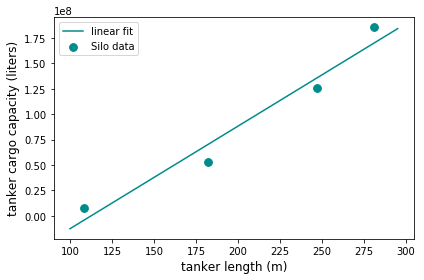

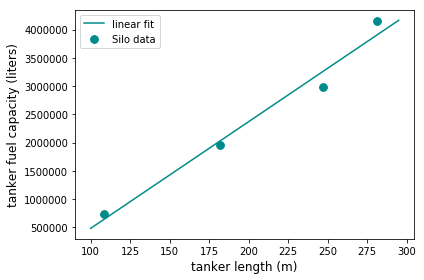

In [3]:
master['vessel_attributes']['tanker']['cargo_fit_coefs'] = numpy.polyfit(
    tanker_df['Silo ship size (m)'], 
    tanker_df['cargo capacity (liters)'], 
    1
)

master['vessel_attributes']['tanker']['fuel_fit_coefs'] = numpy.polyfit(
    tanker_df['Silo ship size (m)'], 
    tanker_df['total fuel capacity (liters)'], 
    1
)

#~~~~ plot tanker fit for fuel and cargo ~~~~
C_cargo = master['vessel_attributes']['tanker']['cargo_fit_coefs']
C_fuel  = master['vessel_attributes']['tanker']['fuel_fit_coefs']
test_length = range(100,300,5)

tanker_cargo_fit = ( 
    C_cargo[1] + 
    C_cargo[0]*test_length 
)
tanker_fuel_fit = ( 
    C_fuel[1] + 
    C_fuel[0]*test_length 
)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    master['vessel_attributes']['tanker']['vessel_lengths'],
    master['vessel_attributes']['tanker']['cargo_capacity'],
    60,
    label='Silo data',
    color='darkcyan'
)
ax1.plot(test_length, tanker_cargo_fit, c='darkcyan', label='linear fit')
plt.xlabel('tanker length (m)',fontsize=12)
plt.ylabel('tanker cargo capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.scatter(
    master['vessel_attributes']['tanker']['vessel_lengths'],
    master['vessel_attributes']['tanker']['fuel_capacity'],
    60,
    label='Silo data',
    color='darkcyan'
)
ax2.plot(test_length, tanker_fuel_fit, c='darkcyan', label='linear fit')
plt.xlabel('tanker length (m)',fontsize=12)
plt.ylabel('tanker fuel capacity (liters)',fontsize=12)
plt.tight_layout()
ax2.legend()
plt.show()

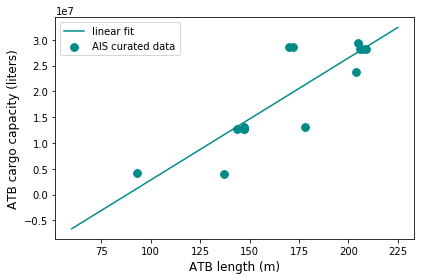

In [4]:
#~~~~ plot ATB fit for vessels with lengths > 50 m ~~~~
C = master['vessel_attributes']['atb']['cargo_fit_coefs']
test_length = range(60,230,5)
test_atb_fit = ( 
    C[1] + 
    C[0]*test_length 
)

atbfig = plt.figure()
ax1 = atbfig.add_subplot(111)
ax1.scatter(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values],
    atb_df['Cargo Capacity (liters)'][good_values],
    60,
    label='AIS curated data',
    color='darkcyan'
)
ax1.plot(test_length, test_atb_fit, c='darkcyan', label='linear fit')
plt.xlabel('ATB length (m)',fontsize=12)
plt.ylabel('ATB cargo capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_cargo_ais.png')
plt.show()

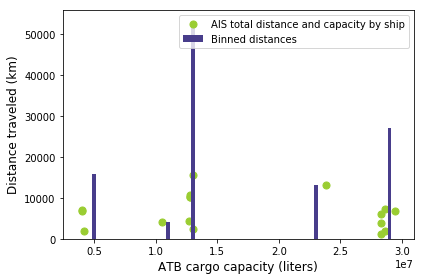

In [5]:
#~~~~ plot  ais pings by vessel lengths  and ais pings by binned lengths, for comparison~~~~
aisfig = plt.figure()
ax1 = aisfig.add_subplot(111)


# add binned-ship-track frequencies
ax1.bar(
    cargo_bin_centers,
    binned_atb_distance_by_cargo,
    width=0.3e6,
    label='Binned distances',
    color='darkslateblue'
)

# add ais-curated frequency data 
good_data = atb_df['Cargo Capacity (liters)']>0
ax1.scatter(
    atb_df['Cargo Capacity (liters)'][good_data],
    atb_distance[good_data],
    50,
    label='AIS total distance and capacity by ship',
    color='yellowgreen'
)

#labels, etc.
plt.xlabel('ATB cargo capacity (liters)',fontsize=12)
plt.ylabel('Distance traveled (km)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_frequency_ais.png')
plt.show() 

In [6]:
len(tanker_df['min length (m)'])

4

In [7]:
range(len(tanker_df['min length (m)']))

range(0, 4)

In [8]:
master['vessel_attributes']['tanker']['cargo_capacity_bin_centers']


[75.0, 175.5, 225.5, 275.5]

In [9]:
master['vessel_attributes']['tanker']['cargo_capacity_bins'] 



[(0, 150), (151, 200), (201, 250), (251, 300)]

In [10]:
tanker_df['cargo capacity (liters)']


0      7748600
1     53000000
2    126211000
3    185447000
Name: cargo capacity (liters), dtype: int64

In [11]:
tanker_df

,min length (m),max length (m),Silo ship size (m),cargo capacity (liters),hfo fuel capacity (liters),diesel fuel capacity (liters),total fuel capacity (liters)
0,0,150,108.50,7748600,687000,53700,740700
1,151,200,182.00,53000000,1826000,130000,1956000
2,201,250,247.24,126211000,2822000,162000,2984000
3,251,300,281.00,185447000,4025000,130000,4155000


In [12]:
tanker_df['hfo fuel capacity (liters)']

0     687000
1    1826000
2    2822000
3    4025000
Name: hfo fuel capacity (liters), dtype: int64

In [13]:
tanker_df = pandas.read_excel(
    '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/data/oil_capacity.xlsx',
    sheet_name='tankers', 
    usecols='B,C,D,E,F,G,H',
    headers=2
)

In [14]:
tanker_df

,min length (m),max length (m),Silo ship size (m),cargo capacity (liters),hfo fuel capacity (liters),diesel fuel capacity (liters),total fuel capacity (liters)
0,0,150,108.50,7748600,687000,53700,740700
1,151,200,182.00,53000000,1826000,130000,1956000
2,201,250,247.24,126211000,2822000,162000,2984000
3,251,300,281.00,185447000,4025000,130000,4155000


In [15]:
master['files']['oil_capacity']

PosixPath('/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/data/oil_capacity.xlsx')

In [16]:
atb_df

,AIS ship tracks,Median ship track distance (km),Vessel Length (AIS + <50 m correction),Total Fuel Capacity (liters),Cargo Capacity (liters)
0,20420.0,0.19,206.00000,539000.74449,28300220.00
1,30690.0,0.13,-99999.00000,78000.00000,10500000.00
2,20609.0,0.33,137.00000,300000.00000,4000000.00
3,39378.0,0.18,-99999.00000,78000.00000,4000000.00
4,26245.0,0.07,92.97000,99800.00000,4200000.00
5,33730.0,0.20,205.00000,567811.50000,29413150.00
6,43829.0,0.30,204.00000,545099.04000,23848500.00
7,8181.0,0.15,209.00000,651995.23299,28300220.00
8,16114.0,0.37,207.00000,651995.23299,28300220.00
9,936.0,0.41,-99999.00000,302832.80000,-99999.00


In [17]:
master['vessel_attributes']['tanker']['fuel_capacity']

[array([ 740700, 1956000, 2984000, 4155000])]

In [18]:
tanker_fuel_fit

array([  482925.56233221,   577303.90868879,   671682.25504538,
         766060.60140196,   860438.94775854,   954817.29411513,
        1049195.64047171,  1143573.98682829,  1237952.33318488,
        1332330.67954146,  1426709.02589804,  1521087.37225463,
        1615465.71861121,  1709844.0649678 ,  1804222.41132438,
        1898600.75768096,  1992979.10403755,  2087357.45039413,
        2181735.79675071,  2276114.1431073 ,  2370492.48946388,
        2464870.83582046,  2559249.18217705,  2653627.52853363,
        2748005.87489022,  2842384.2212468 ,  2936762.56760338,
        3031140.91395997,  3125519.26031655,  3219897.60667313,
        3314275.95302972,  3408654.2993863 ,  3503032.64574288,
        3597410.99209947,  3691789.33845605,  3786167.68481264,
        3880546.03116922,  3974924.3775258 ,  4069302.72388239,
        4163681.07023897])